In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

import simple_pinn
import utils
import cv_mesh
import cv_solver
import athena_reader

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(utils)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)
importlib.reload(athena_reader)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

# torch.set_default_dtype(torch.float64)

In [2]:
t_domain = [0.0, 0.1]
x_domain = [-1.0, 1.0]
Nt = 128
Nx = 512
mesh = cv_mesh.CVMesh(
    t_domain, x_domain, Nt, Nx, quad_pts=(4, 4), quad_rule="composite_trapezoid"
)
mesh.to(DEVICE)


# the primitive set here is (rho, v_x, v_y, v_z, B_x, B_y, B_z, E)


def mhd_ideal_gas_eos(state_vec, gamma=2.0):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    E = state_vec[..., 7]

    e = torch.divide(
        E
        - 0.5 * rho * (v_x**2 + v_y**2 + v_z**2)
        - 0.5 * (B_x**2 + B_y**2 + B_z**2),
        rho,
    )

    eps = 1.0e-6
    e = torch.clamp(e, min=eps)
    rho = torch.clamp(rho, min=eps)

    s = torch.log(e) / (gamma - 1.0) - torch.log(rho)
    p = (gamma - 1.0) * rho * e
    return s, p


def mhd_state_vec_to_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    E = state_vec[..., 7]

    _, p = eos(state_vec)
    p_star = p + 0.5 * (B_x**2 + B_y**2 + B_z**2)

    F_t = torch.stack([rho, rho * v_x, rho * v_y, rho * v_z, B_x, B_y, B_z, E], dim=-1)
    F_x = torch.stack(
        [
            rho * v_x,
            rho * v_x**2 + p_star - B_x**2,
            rho * v_x * v_y - B_x * B_y,
            rho * v_x * v_z - B_x * B_z,
            torch.zeros_like(rho),
            v_x * B_y - v_y * B_x,
            v_x * B_z - v_z * B_x,
            (E + p_star) * v_x - B_x * (v_x * B_x + v_y * B_y + v_z * B_z),
        ],
        dim=-1,
    )
    return F_t, F_x


def mhd_state_vec_to_entropy_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]

    s, _ = eos(state_vec)

    F_t = (-s * rho).unsqueeze(-1)
    F_x = (-s * rho * v_x).unsqueeze(-1)
    return F_t, F_x


def briowu_ic_state_vec_evaluation(eval_points, eos):
    gamma = 2.0
    rho_left, rho_right = 1.0, 0.125
    B_x = 0.75
    B_y_left, B_y_right = 1.0, -1.0
    p_left, p_right = 1.0, 0.1
    E_left = p_left / (gamma - 1.0) + 0.5 * (B_x**2 + B_y_left**2)
    E_right = p_right / (gamma - 1.0) + 0.5 * (B_x**2 + B_y_right**2)

    rho = torch.where(eval_points[..., 1] < 0.0, rho_left, rho_right)
    v_x = torch.zeros_like(eval_points[..., 1])
    v_y = torch.zeros_like(eval_points[..., 1])
    v_z = torch.zeros_like(eval_points[..., 1])
    B_x = torch.ones_like(eval_points[..., 1]) * B_x
    B_y = torch.where(eval_points[..., 1] < 0.0, B_y_left, B_y_right)
    B_z = torch.zeros_like(eval_points[..., 1])
    E = torch.where(eval_points[..., 1] < 0.0, E_left, E_right)

    return torch.stack([rho, v_x, v_y, v_z, B_x, B_y, B_z, E], dim=-1)


athena_data = athena_reader.AthenaReader(
    "../scratch/briowu",
    ("rho", "vel1", "vel2", "vel3", "Bcc1", "Bcc2", "Bcc3", "press"),
)


def analytic_briowu_soln(eval_points, eos, gamma=2.0):
    # okay so it's not "analytic" but we can take Athena++ as ground truth for the forward problem here
    device = eval_points.device
    athena_state_vec = athena_data(eval_points.cpu())
    # athena returns (rho, v_x, v_y, v_z, B_x, B_y, B_z, p),
    # but we need to convert p to E
    rho = athena_state_vec[..., 0]
    v_x = athena_state_vec[..., 1]
    v_y = athena_state_vec[..., 2]
    v_z = athena_state_vec[..., 3]
    B_x = athena_state_vec[..., 4]
    B_y = athena_state_vec[..., 5]
    B_z = athena_state_vec[..., 6]
    p = athena_state_vec[..., 7]
    E = (
        p / (gamma - 1.0)
        + 0.5 * rho * (v_x**2 + v_y**2 + v_z**2)
        + 0.5 * (B_x**2 + B_y**2 + B_z**2)
    )
    athena_state_vec[..., 7] = E
    return athena_state_vec.to(device)


model = simple_pinn.BrioAndWuPINN(
    2,
    [64, 64, 64, 64, 64, 64, 64, 64],
    8,
    mesh,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    use_bias_in_output_layer=False,
).to(DEVICE)
print(model)

solver = cv_solver.CVSolver(
    mesh,
    model,
    mhd_state_vec_to_fluxes,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    state_vec_to_entropy_fluxes=mhd_state_vec_to_entropy_fluxes,
    analytic_soln=analytic_briowu_soln,
    component_names=["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "E"],
)

BrioAndWuPINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
  )
  (head): Linear(in_features=64, out_features=8, bias=False)
  (activation): ReLU()
)


In [3]:
def train(optimizer, n_epochs, entropy_loss_weight=0.0):
    for epoch in range(n_epochs):
        cv_pde_loss, cv_entropy_loss = solver.forward()
        optimizer.zero_grad()
        loss = cv_pde_loss + entropy_loss_weight * cv_entropy_loss
        loss.backward()
        optimizer.step()
        if epoch % 2000 == 0:
            print(
                f"Epoch {epoch}: PDE loss: {cv_pde_loss.item():.3e}, Entropy loss: {cv_entropy_loss.item():.3e}"
            )

In [4]:
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-2))
train(optimizer, 2000)
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-3))
train(optimizer, 20_000, entropy_loss_weight=0.1)
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-4))
train(optimizer, 20_000, entropy_loss_weight=0.1)
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-5))
train(optimizer, 20_000, entropy_loss_weight=0.1)

Epoch 0: PDE loss: 2.739e-02, Entropy loss: 1.574e-03
Epoch 0: PDE loss: 3.035e-06, Entropy loss: 3.783e-07
Epoch 2000: PDE loss: 9.162e-07, Entropy loss: 1.735e-08
Epoch 4000: PDE loss: 5.470e-07, Entropy loss: 1.958e-08
Epoch 6000: PDE loss: 5.039e-07, Entropy loss: 2.076e-08
Epoch 8000: PDE loss: 3.874e-07, Entropy loss: 9.569e-09
Epoch 10000: PDE loss: 3.518e-07, Entropy loss: 1.824e-08
Epoch 12000: PDE loss: 3.402e-07, Entropy loss: 1.748e-08
Epoch 14000: PDE loss: 3.490e-07, Entropy loss: 1.781e-08
Epoch 16000: PDE loss: 2.952e-07, Entropy loss: 2.134e-08
Epoch 18000: PDE loss: 3.173e-07, Entropy loss: 1.648e-08
Epoch 0: PDE loss: 2.797e-07, Entropy loss: 1.476e-08
Epoch 2000: PDE loss: 2.379e-07, Entropy loss: 1.608e-08
Epoch 4000: PDE loss: 2.314e-07, Entropy loss: 1.616e-08
Epoch 6000: PDE loss: 2.272e-07, Entropy loss: 1.689e-08
Epoch 8000: PDE loss: 2.233e-07, Entropy loss: 1.714e-08
Epoch 10000: PDE loss: 2.207e-07, Entropy loss: 1.766e-08
Epoch 12000: PDE loss: 2.182e-07, 

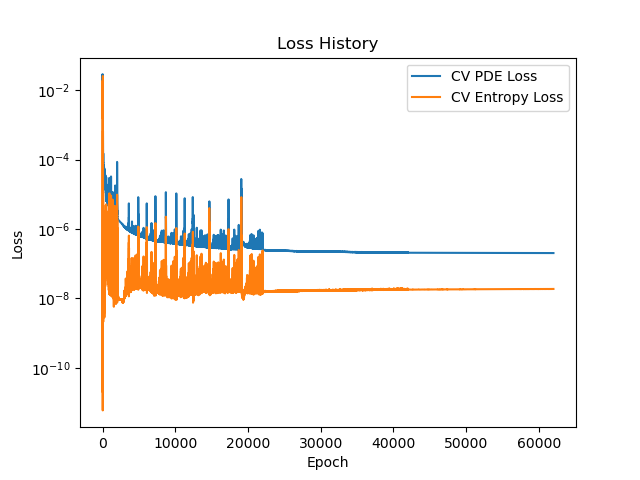

In [5]:
solver.plot_loss_history()

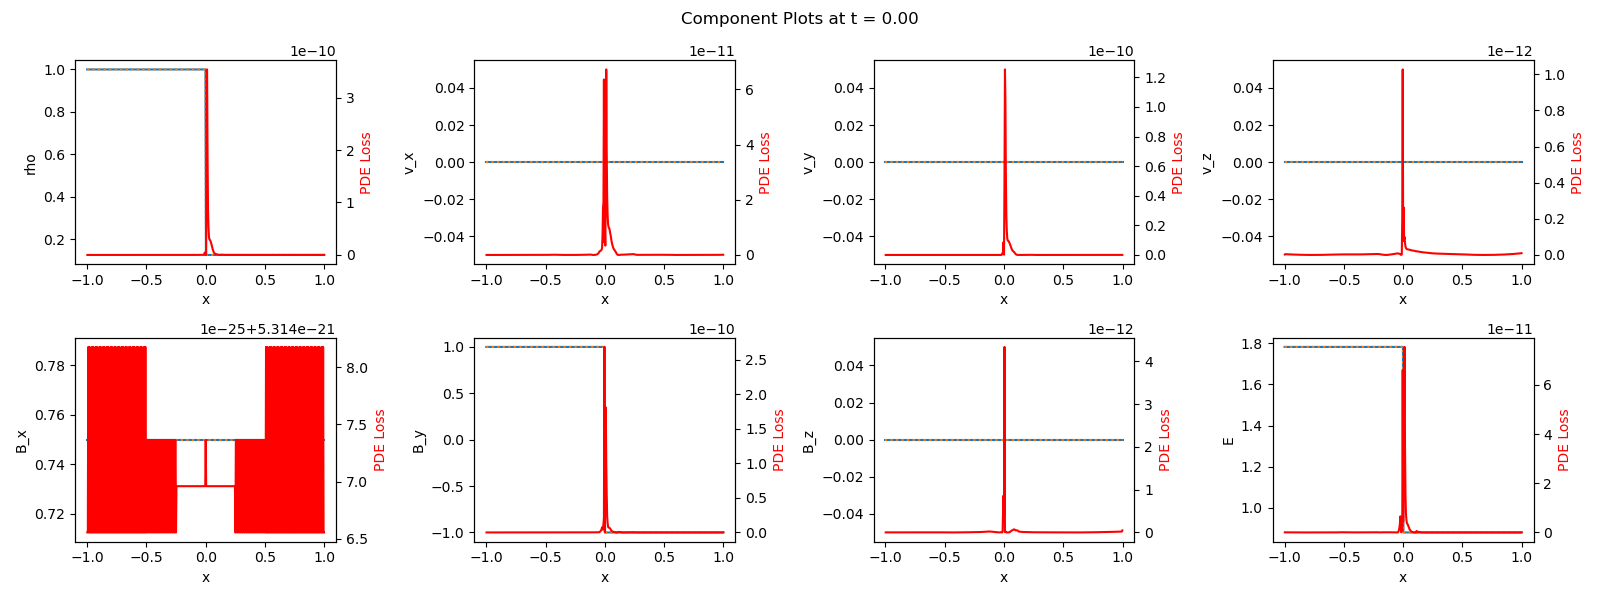

In [6]:
solver.plot_components(
    0,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    loss_to_plot="PDE",
)

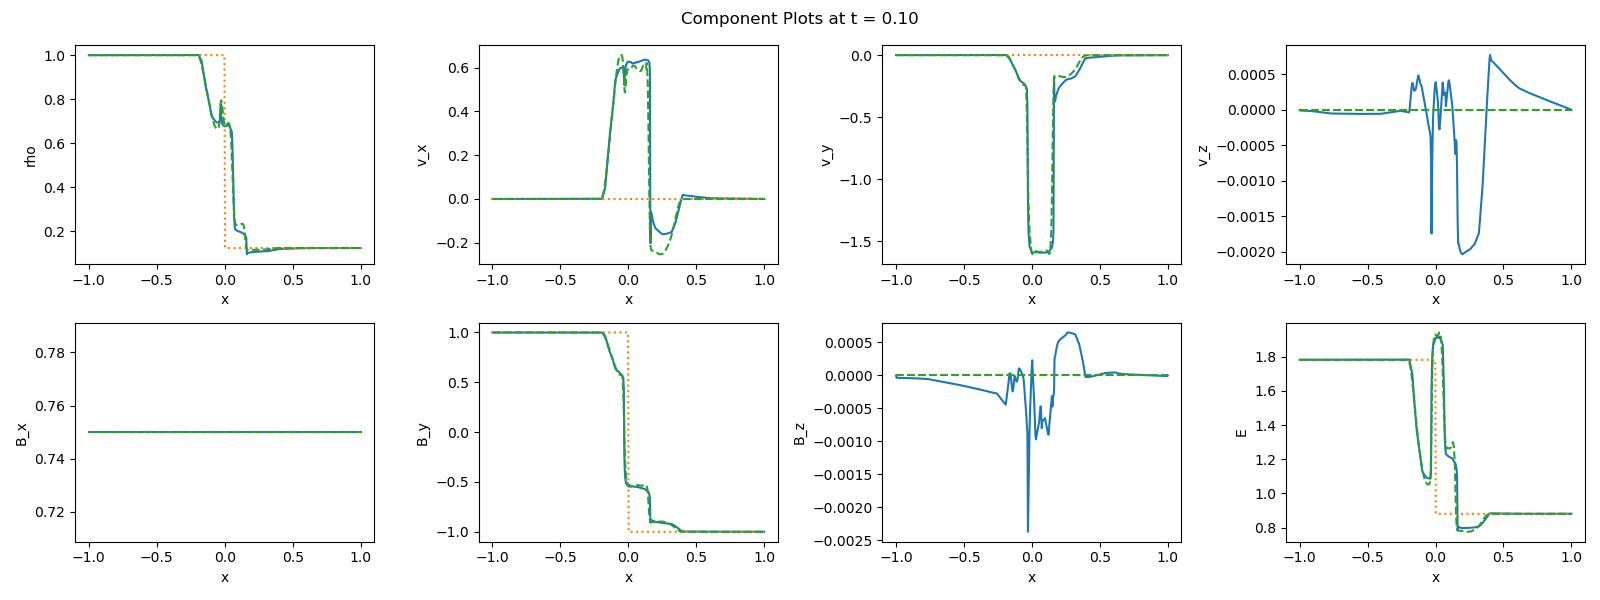

In [7]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    # loss_to_plot="PDE",
)

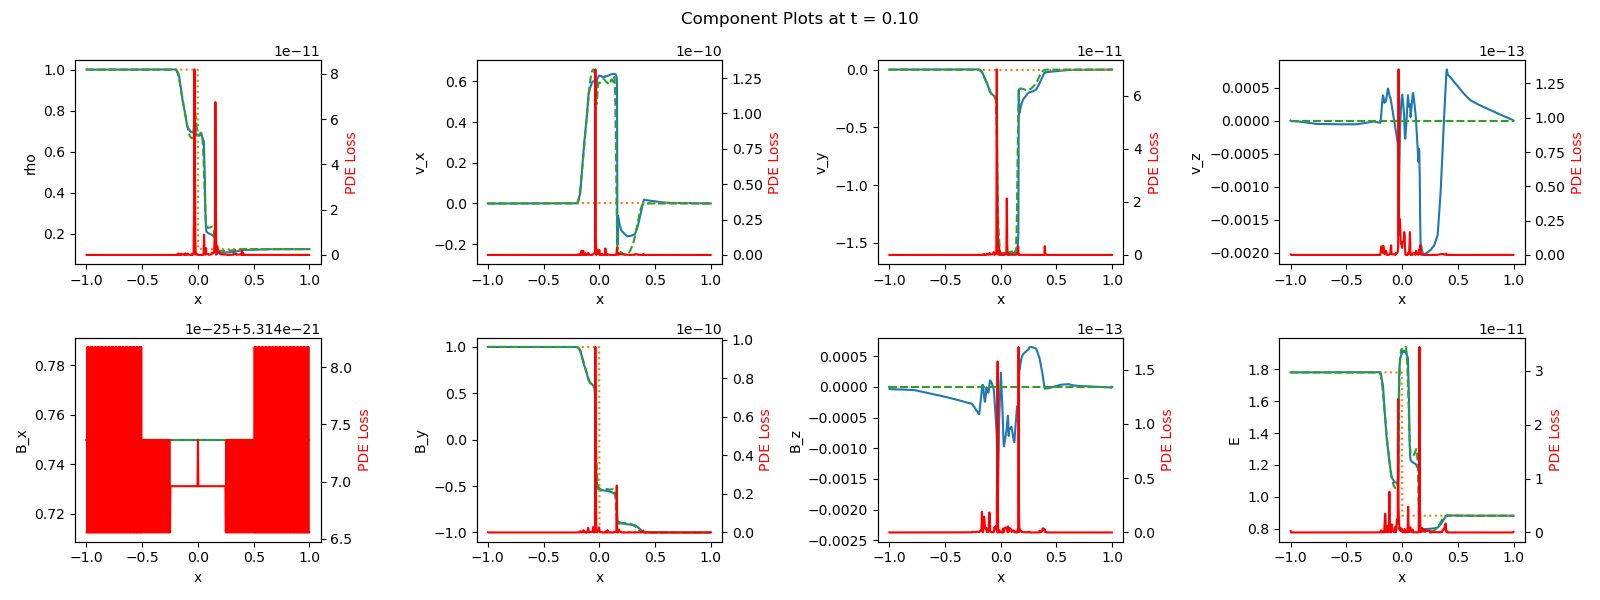

In [9]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    loss_to_plot="PDE",
)

In [8]:
# solver.animate_components(
#     "brio_and_wu.gif",
#     num_rows=2,
#     num_cols=4,
#     with_ics=True,
#     with_analytic_soln=True,
# )